In [1]:
#Instalo e importo paquetes 
!pip install pandas

import pandas as pd 
import numpy as np 
import os
from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


<h3 style="color: navy;">Parte I: Creación de variables, histogramas, kernels y resumen de la base de datos final</h3>
<p> 
La idea de esta primera parte es que completen la limpieza de la base de datos que contiene las observaciones del primer trimestre de 2005 y del 
primer trimestre de 2025. La base final a trabajar resultante debe incluir todas las variables presentes en ambos trimestres, expresadas de manera 
homogénea. Es decir, si la variable CH04 en 2005 toma los valores “Hombre” o “Mujer”, y en 2025 toma los valores 1 y 2, la variable limpia 
en la base final debe tener solamente dos valores consistentes. 
</p>



In [2]:
## INDIVIDUOS  ##############

#SUBO EL SET DE DATOS INDIVISUALES DEL PRIMER TRIMESTRE DE 2025
t0125 = pd.read_excel('usu_individual_T125.xlsx')

#SUBO EL SET DE DATOS INDIVISUALES DEL PRIMER TRIMESTRE DE 2005
t0105 = pd.read_stata('Individual_t105.dta')

############# HOGARES  ##############

#SUBO EL SET DE DATOS HOGARES DEL PRIMER TRIMESTRE DE 2025
th0125 = pd.read_excel('usu_hogar_T125.xlsx')
#th0125

#SUBO EL SET DE DATOS HOGARES DEL PRIMER TRIMESTRE DE 2005
th0105 = pd.read_stata('Hogar_t105.dta')



In [3]:
#CREO UNA FUNCION QUE ME TRANSFORME EL TIPO DE DATO DE LA COLUMNA EN CUESTION.
#LE DEBO CARGAR EL NOMBRE DEL DATAFRAME, EL NOMBRE DE LA COLUMNA Y EL MAPEO DE DATOS QUE DEBE TRANSFORMAR

def mapear_columna(df, columna, diccionario):
    
    #Creo esta lista para ir depositando los errores que vaya encontrado la transformacion y después ver qué corregir 
    errores = []

    # Asegura que la columna esté en formato string para comparar
    df[columna] = df[columna].astype(str)

    #Armo un bucle para que recorra todas las celdas de la columna y vaya tranformando los datos segun el diccionario.
    #Para ello utilizo la función .at[] con la que modifico una sola celda en un DataFrame, usando la combinación de índice y nombre de columna.
    
    for i in df.index:
        valor = df.at[i, columna]
        if valor in diccionario:
            df.at[i, columna] = diccionario[valor]
        else:
            errores.append((i, valor))

    # Convierte la columna al tipo int64 si todo salió bien
    try:
        df[columna] = df[columna].astype('int64')
    except ValueError:
        pass  # Si hay errores, no se puede convertir

    return df, errores

In [4]:
############# EMPIEZO A HOMOGENEIZAR LOS DATOS  ##############

#region 2005
mapa = {    'Gran Buenos Aires': 1,    'NOA':40,    'NEA':41,    'Cuyo':42,    'Pampeana':43,    'Patagónica':44 }
t0105, errores = mapear_columna(t0105, 'region', mapa)


#aglomerado 2005
mapa = {'Gran La Plata': 2, 'Bahía Blanca - Cerri': 3,'Gran Rosario': 4,'Gran Santa Fe': 5,'Gran Paraná': 6,'Posadas': 7,
        'Gran Resistencia': 8, 'Gran Mendoza': 10,'Corrientes': 12,'Gran Córdoba': 13,'Concordia': 14,'Formosa': 15,
        'Cdro. Rivadavia – Rada Tilly': 9, 'Comodoro Rivadavia - Rada Tilly':9,
        'Neuquén – Plottier': 17,'Neuquén - Plottier':17,
        'S.del Estero - La Banda': 18,'Santiago del Estero - La Banda':18,
        'Jujuy - Palpalá': 19,'Río Gallegos': 20,'Gran Catamarca': 22,'Salta': 23,'La Rioja': 25,
        'San Luis - El Chorrillo': 26,'Gran San Juan': 27,'Gran Tucumán - T. Viejo': 29, 'Gran Tucumán - Tafí Viejo':29,
        'Santa Rosa - Toay': 30, 'Ushuaia - Río Grande': 31,'Ciudad de Buenos Aires': 32,'Partidos del GBA': 33,
        'Mar del Plata - Batán': 34,'Río Cuarto': 36
}
t0105, errores = mapear_columna(t0105, 'aglomerado', mapa)

In [5]:
#ch3 2005
mapa = {       'Jefe/a': 1,     'Jefe': 1,     'Cónyuge/pareja': 2,    'Cónyuge/Pareja': 2,    'Hijo/a/hijastro/a': 3,  'Hijo/Hijastro': 3,
         'Yerno/nuera': 4,   'Yerno/Nuera': 4,    'Nieto/a': 5,            'Nieto': 5,         'Madre/padre': 6,         'Madre/Padre': 6,
         'Suegro/a': 7,             'Suegro': 7, 'Hermano/a': 8,          'Hermano': 8,
    'Otros familiares': 9,    'No familiares': 10
}
t0105, errores = mapear_columna(t0105, 'ch03', mapa)

#ch04 2005 lo llevo a numerico dummies.. En 2025, retransformo como dummie llevando a mujer a 0 en lugar de 2
mapa = {    'Varón': 1,    'Mujer': 0  }
t0105, errores = mapear_columna(t0105, 'ch04', mapa)

t0125['CH04'] = np.where(t0125['CH04']  ==  1,1,0)

######################################################################
#Para el 2005 - Llevo de 1 a 97 años para homogeneizar xq en 2005 a ese sector lo trataban con un texto
t0105['ch06'] = t0105['ch06'].astype(str)

t0105 = t0105.loc[
    (t0105['ch06'] != 'Menos de 1 año') & 
    (t0105['ch06'] != '98 y más años')
]

t0105['ch06'] = pd.to_numeric(t0105['ch06'], errors='coerce')

#############

#Para el 2025
t0125['CH06'] = t0125['CH06'].astype(str)

t0125 = t0125.loc[
    (t0125['CH06'] != 'Menos de 1 año') & 
    (t0125['CH06'] != '98 y más años') &
    (t0125['CH06'] != '98') & (t0125['CH06'] != '99') & (t0125['CH06'] != '100') & (t0125['CH06'] != '101') & 
    (t0125['CH06'] != '102') & (t0125['CH06'] != '103') & 
    (t0125['CH06'] != '-1') 
]

#una vez recodificado transformo el tipo de dato
t0125['CH06'] = pd.to_numeric(t0125['CH06'], errors='coerce')


In [6]:
#####################################################
#CH07 - 

mapa = {    'Unido':1, 'Casado':2, 'Separado o divorciado':3, 'Viudo':4, 'Soltero':5,'Ns/Nr':0 }

t0105, errores = mapear_columna(t0105, 'ch07', mapa)

#Tambien haré Null los valores 0, 0.0 y los 99
t0105['ch07'] = t0105['ch07'].replace(0, np.nan)
t0105['ch07'] = t0105['ch07'].replace('0.0', np.nan)
t0105['ch07'] = t0105['ch07'].replace(99, np.nan)

#####################################################
#CH08
# Hay items escritos de maneras diferentes, pero como los diccionarios nos permites repetir valores pero No Keys, 
# repetimos el código tipificado con su key diferente

mapa = {
'Obra social (incluye PAMI)':1, 'Mutual/Prepaga/Servicio de emergencia':2, 'Planes y seguros públicos':3, 'No paga ni le descuentan':4, 'Ns./Nr.':9, 
'Obra social y mutual/prepaga/servicio de emergencia':12, 'Obra social y planes y seguros públicos':13, 
'Mutual /prepaga / servicio de emergencia / Planes y Seguros Públicos':23, 
'Mutual/prepaga/servicio de emergencia/planes y seguros públi':23,
'Obra social, mutual/prepaga/servicio de emergencia y planes':123, 
'Obra social, mutual / prepaga / servicio de emergencia y Planes y Seguros Públicos':123
}

t0105, errores = mapear_columna(t0105, 'ch08', mapa)
#####################################################

#Para ch12
# Se tomara como null los codigos no tipificados como el 0 o 99, el Ns/Nc, y el 0.0 que aparecen entre los registros.

mapa = {'Jardín/Preescolar' : 1,	'Jardín/preescolar' : 1, 'Primario' : 2, 'EGB' : 3, 'Secundario' : 4, 'Polimodal' : 5, 
        'Terciario' : 6, 'Universitario' : 7, 'Posgrado universitario' : 8, 'Posgrado Universitario' : 8, 
            'Educación especial (discapacidad)' : 9,  'Educación especial (discapacitado)':9, 'Ns./Nr.':0, 'Ns/Nr.':0, '99':0,'0.0':0
           }

t0105, errores = mapear_columna(t0105, 'ch12', mapa)

t0105['ch12'] = t0105['ch12'].replace(0, np.nan)
t0125['CH12'] = t0125['CH12'].replace(0, np.nan)


##############################################################################################################################
#Para ch13
# acá existe tupificacion, recategorizo valores como 0 o 0.0 a "no sabe/ no contesta"
mapa = {'Sí': 1, 'No':2, 
        'Ns/Nr':9, 'Ns./Nr.':9, '0':9, '0.0':9        }

t0105, errores = mapear_columna(t0105, 'ch13', mapa)

t0105['ch13'] = t0105['ch13'].replace(9, np.nan)
t0125['CH13'] = t0125['CH13'].replace(9, np.nan)

##############################################################################################################################
#CH14

#Primero lo llevo a string para despues llevarlo a numerico al campo del ultimo curso aprobado

t0105['ch14'] = t0105['ch14'].astype(str).str.strip()
t0105['ch14'] = pd.to_numeric(t0105['ch14'], errors='coerce')

t0125['CH14'] = np.where(((t0125['CH14']  ==  98)|(t0125['CH14']  ==  99)|(t0125['CH14']  ==  '0.0')|(t0125['CH14']  ==  'Ns/Nr.')),np.nan,t0125['CH14'])
t0105['ch14'] = np.where(((t0105['ch14']  ==  98)|(t0105['ch14']  ==  99)|(t0105['ch14']  ==  '0.0')|(t0105['ch14']  ==  'Ns/Nr.')),np.nan,t0105['ch14'])

#reemplaza los valores nulos por el 0, que si esta tipificado aqui
t0105['ch14'] = t0105['ch14'].fillna(0)

# Hay un dato de un terciario que manifiesta 9 años en la ch14.. Lo reconsidero a 3 años 

t0125['CH14'] = np.where((t0125['CH14'] > 3) & (t0125['CH12'] == 6), 4, t0125['CH14'] )


In [7]:

#nivel_ed


#Para el Nivel educativo

mapa = {'Primaria Completa':2, 'Primaria Incompleta (incluye educación especial)':1, 'Secundaria Completa':4, 
            'Secundaria Incompleta':3, 'Sin instrucción':7, 'Superior Universitaria Completa':6, 
            'Superior Universitaria Incompleta':5, 'Ns/Nr':9
           }

t0105, errores = mapear_columna(t0105, 'nivel_ed', mapa)

#############################################################

#estado

mapa = {'Entrevista individual no realizada (no respuesta al cuestion':0, 
                'Ocupado':1, 'Desocupado':2, 'Inactivo':3, 'Menor de 10 años':4
               }

t0105, errores = mapear_columna(t0105, 'estado', mapa)

#############################################################

#Para cat_ocup - la categoria ocupacional

mapa = {'Patrón':1, 'Cuenta propia':2, 'Obrero o empleado':3,
              'Trabajador familiar sin remuneración':4,'Nr/Nr':9
             }
t0105, errores = mapear_columna(t0105, 'cat_ocup', mapa)

t0105['cat_ocup'] = pd.to_numeric(t0105['cat_ocup'], errors='coerce')

#############################################################

#CAT_INAC

cat_inac_map = {'Ama de casa':4, 'Discapacitado':6, 'Estudiante':3, 'Jubilado/pensionado':1, 
                'Menor de 6 años':5, 'Otros':7, 'Rentista':2
               }
t0105, errores = mapear_columna(t0105, 'cat_inac', cat_inac_map)

t0105['cat_inac'] = pd.to_numeric(t0105['cat_inac'], errors='coerce')

#############################################################

#En p21 hay valores -9, pasaran a ser considerados como cero

t0105['p21'] = t0105['p21'].replace(-9, np.nan)
t0125['P21'] = t0125['P21'].replace(-9, np.nan)

t0125['P21'] = t0125['P21'].fillna(0)

#############################################################
# Se termina de limpiar datos de ambas bases. 

#Como el valor "0" no esta tipificado dentro de los cuadros de referencia, lo reemplazare por un valor nulo

t0105['cat_inac'] = t0105['cat_inac'].replace(0, np.nan)
t0125['CAT_INAC'] = t0125['CAT_INAC'].replace(0, np.nan)

t0105['cat_ocup'] = t0105['cat_ocup'].replace(0, np.nan)
t0125['CAT_OCUP'] = t0125['CAT_OCUP'].replace(0, np.nan)

#Ahora, a los Nulos de  CAT_OCUP los convierto en el codigo de Ns/Nc que si esta tipificado
t0105['cat_ocup'] = t0105['cat_ocup'].fillna(9)



In [8]:

#PP04B_COD


t0105['pp04b_cod'] = pd.to_numeric(t0105['pp04b_cod'], errors='coerce')
t0105['pp04b_cod'] = t0105['pp04b_cod'].replace(0, np.nan)

#Porque sino despues no voy a poder concatenar los 2 Dataframes 
t0125['PP04B_COD'] = pd.to_numeric(t0125['PP04B_COD'], errors='coerce')

##############################################################################################################################
# PP3F_TOT y PP3E_TOT 


#Trasformo los valores mayores a 112hs (16hs diarios) semanales se los considerará nulos

t0125['PP3E_TOT'] = np.where(t0125['PP3E_TOT'] >112,np.nan,t0125['PP3E_TOT'])
t0105['pp3e_tot'] = np.where(t0105['pp3e_tot'] >112,np.nan,t0105['pp3e_tot'])

t0125['PP3F_TOT'] = np.where(t0125['PP3F_TOT'] >112,np.nan,t0125['PP3F_TOT'])
t0105['pp3f_tot'] = np.where(t0105['pp3f_tot'] >112,np.nan,t0105['pp3f_tot'])


#TRANSFORMO LOS DATOS EN 0´s EN NULLs Y A LOS 999 EN 0

t0125['PP3E_TOT'] = np.where(t0125['PP3E_TOT']  ==  999,np.nan,t0125['PP3E_TOT'])
t0105['pp3e_tot'] = np.where(t0105['pp3e_tot']  ==  999,np.nan,t0105['pp3e_tot'])


t0125['PP3F_TOT'] = np.where(t0125['PP3F_TOT']  ==  999,np.nan,t0125['PP3F_TOT'])
t0105['pp3f_tot'] = np.where(t0105['pp3f_tot']  ==  999,np.nan,t0105['pp3f_tot'])


t0105['pp3e_tot'] = t0105['pp3e_tot'].replace(0, np.nan)
t0125['PP3E_TOT'] = t0125['PP3E_TOT'].replace(0, np.nan)

##############################################################################################################################

#AGREGO UNA COLUMNA EN CADA TRIMESTRE PARA INDICAR EL AÑO

t0105['ANIO'] = np.int64(2005)
t0125['ANIO'] = np.int64(2025)


In [9]:

#AHORA VOY ESTABLECER LAS COLUMNAS CON LAS QUE ME VOY A QUEDAR, EN LAS 2 TABLAS

t0105_sel_c = t0105[[
'CODUSU', 'nro_hogar', 'region', 'aglomerado', 'pondera', 'ch03', 'ch04', 'ch06', 'ch07', 'ch08', 'ch12', 'ch13', 'ch14', 
    'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'pp3e_tot', 'pp3f_tot', 'pp04b_cod', 'p21', 'itf', 'ipcf', 'ANIO'
]].copy()

t0125_sel_c = t0125[[
'CODUSU', 'NRO_HOGAR', 'REGION', 'AGLOMERADO', 'PONDERA', 'CH03', 'CH04', 'CH06', 'CH07', 'CH08', 'CH12', 'CH13', 'CH14', 
    'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'CAT_INAC', 'PP3E_TOT', 'PP3F_TOT', 'PP04B_COD', 'P21', 'ITF', 'IPCF', 'ANIO'
]].copy()



In [10]:
#Tengo que renombrar las columnas para que ambos dataframes tengan igual nombre porque sino 
#no voy a poder poder concatenar correctamente (en la misma columna, una abajo de la otra)los 2 DataFrames

t0105_sel_c = t0105_sel_c.rename(columns={
'nro_hogar': 'NRO_HOGAR',
'region':'REGION',
'aglomerado': 'AGLOMERADO',
'pondera': 'PONDERA',
'ch03': 'CH03',
'ch04': 'CH04',
'ch06': 'CH06',
'ch07': 'CH07',
'ch08': 'CH08',
'ch12': 'CH12', 
'ch13': 'CH13', 
'ch14': 'CH14',
'nivel_ed': 'NIVEL_ED',
'estado': 'ESTADO',
'cat_ocup': 'CAT_OCUP',
'cat_inac': 'CAT_INAC',
'pp3e_tot': 'PP3E_TOT', 
'pp3f_tot': 'PP3F_TOT',
'pp04b_cod': 'PP04B_COD',
'p21':'P21',
'itf':'ITF',
'ipcf': 'IPCF'
})

#Ahora uno a las 2 bases de datos individuales del 2.a

sel_indiv_c = pd.concat([t0125_sel_c, t0105_sel_c], axis=0, ignore_index=True)



In [11]:
# AHORA UNON DE HOGARES


In [12]:
# documento de HOGARES
#Para TIPO DE VIVIENDA

#Defino el diccionario de valores que debe buscar y reemplazar
iv1_map = {
    'Casa': 1,     'Departamento': 2,
    'Pieza  de inquilinato': 3,    'Pieza  de hotel/Pensión': 4,
    'Local no construido para habitacion': 5,  'Otros': 6
}

th0105, errores = mapear_columna(th0105, 'iv1', iv1_map)

#una vez recodificado transformo el tipo de dato a numerico
th0105['iv1'] = pd.to_numeric(th0105['iv1'], errors='coerce')

####################################################################################################
#Para EN CUANTOS AMBIENTES VIVE

#Aqui solo transformo el tipo de dato a numerico. La opcion errors='coerce' deja el dato como NA´s.
th0105['iv2'] = pd.to_numeric(th0105['iv2'], errors='coerce')

####################################################################################################


#Para TIENE AGUA

#Defino el diccionario de valores que debe buscar y reemplazar
iv6_map = {
    'Por cañeria dentro de la vivienda': 1,     'Fuera de la vivienda pero dentro del terreno': 2,    'Fuera del terreno': 3
            }
#Para meter los errores en una lista que vaya encontrado la transformacion y después que pueda imprimir y ver de corregirlos

th0105, errores = mapear_columna(th0105, 'iv6', iv6_map)

#una vez recodificado transformo el tipo de dato a numerico
th0105['iv6'] = pd.to_numeric(th0105['iv6'], errors='coerce')
####################################################################################################

# tomare a la variable de TIENE LETRINA con una Dummies, recodificandola en 0 y 1.

th0105['iv8'] = np.where(th0105['iv8']  ==  'Sí', 1, 0)
th0105['iv8'] = np.where(th0105['iv8']  ==  'Sí', 1, 0)


#una vez recodificado transformo el tipo de dato
th0105['iv8'] = th0105['iv8'].astype('int64')

th0105['iv8'] = th0105['iv8'].replace(0, np.nan)
th0125['IV8'] = th0125['IV8'].replace(0, np.nan)

####################################################################################################

#Para COMBUSTIBLE PARA COCINAR

#Defino el diccionario de valores que debe buscar y reemplazar
ii8_map = {
    'Gas de red': 1,     'Gas de tubo/garrafa': 2,    'Kerosene/leña/carbon': 3,    'Otro': 4
            }

th0105, errores = mapear_columna(th0105, 'ii8', ii8_map)

#una vez recodificado transformo el tipo de dato a numerico
th0105['ii8'] = pd.to_numeric(th0105['ii8'], errors='coerce')


th0105['ii8'] = th0105['ii8'].replace(0, np.nan)
th0125['II8'] = th0125['II8'].replace(0, np.nan)


#th0105

In [13]:
#Selecciono  las filas y columnas con la que trabajaré de cada trimestre

th0105_sel_c = th0105[['CODUSU', 'nro_hogar', 'iv1', 'iv2', 'iv6', 'iv8', 'ii8','IX_Tot']].copy()
#sel_th0105

th0125_sel_c = th0125[['CODUSU','NRO_HOGAR','IV1', 'IV2', 'IV6', 'IV8', 'II8','IX_TOT']].copy()
#sel_th0125


In [14]:
th0105_sel_c = th0105_sel_c.rename(columns={
'nro_hogar': 'NRO_HOGAR',
'iv1': 'IV1',
'iv2': 'IV2',
'iv6': 'IV6',
'iv8': 'IV8',
'ii8': 'II8',
'IX_Tot': 'IX_TOT'      
})

#Ahora uno a las 2 bases de datos individuales del 2.a

sel_hogar_c = pd.concat([th0125_sel_c, th0105_sel_c], axis=0, ignore_index=True)


In [15]:
# Ahora se va a cruzar los dataframes de individuos y hogares
union_eph_1 = pd.merge(sel_indiv_c,sel_hogar_c, on=('CODUSU','NRO_HOGAR'), how='left')

union_eph_1[['CODUSU','NRO_HOGAR','IV1', 'IV2', 'IV6', 'IV8', 'II8',
           'CODUSU', 'NRO_HOGAR', 'REGION', 'AGLOMERADO', 'PONDERA', 
           'CH03', 'CH04', 'CH06', 'CH07', 'CH08', 'CH12', 'CH13', 'CH14', 
           'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'CAT_INAC', 'PP3E_TOT', 'PP3F_TOT', 'PP04B_COD', 'P21',
           'ITF', 'IPCF']]

,CODUSU,NRO_HOGAR,IV1,IV2,IV6,IV8,II8,CODUSU,NRO_HOGAR,REGION,...,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP3E_TOT,PP3F_TOT,PP04B_COD,P21,ITF,IPCF
0,TQRMNOVQVHJOLOCDEFKID00875778,1.0,1.0,3.0,1.0,1.0,2.0,TQRMNOVQVHJOLOCDEFKID00875778,1.0,43,...,4,1,3.0,NaN,24.0,0.0,4808.0,200000.0,1028000.0,205600.0
1,TQRMNOVQVHJOLOCDEFKID00875778,1.0,1.0,3.0,1.0,1.0,2.0,TQRMNOVQVHJOLOCDEFKID00875778,1.0,43,...,1,4,NaN,3.0,NaN,NaN,NaN,0.0,1028000.0,205600.0
2,TQRMNOVQVHJOLOCDEFKID00875778,1.0,1.0,3.0,1.0,1.0,2.0,TQRMNOVQVHJOLOCDEFKID00875778,1.0,43,...,7,4,NaN,5.0,NaN,NaN,NaN,0.0,1028000.0,205600.0
3,TQRMNOUPQHLOLOCDEFKID00851757,1.0,2.0,3.0,1.0,1.0,2.0,TQRMNOUPQHLOLOCDEFKID00851757,1.0,43,...,5,1,2.0,NaN,70.0,0.0,4808.0,400000.0,690000.0,230000.0
4,TQRMNOUPQHLOLOCDEFKID00851757,1.0,2.0,3.0,1.0,1.0,2.0,TQRMNOUPQHLOLOCDEFKID00851757,1.0,43,...,1,3,NaN,3.0,NaN,NaN,NaN,0.0,690000.0,230000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91426,288015,1.0,1.0,5.0,NaN,NaN,1.0,288015,1.0,44,...,3,3,9.0,3.0,NaN,0.0,NaN,0.0,3800.0,950.0
91427,288015,1.0,1.0,5.0,NaN,NaN,1.0,288015,1.0,44,...,2,3,9.0,3.0,NaN,0.0,NaN,0.0,3800.0,950.0
91428,288294,1.0,1.0,4.0,NaN,NaN,1.0,288294,1.0,44,...,3,1,3.0,NaN,63.0,0.0,5307.0,2387.0,4068.0,1356.0
91429,288294,1.0,1.0,4.0,NaN,NaN,1.0,288294,1.0,44,...,4,1,3.0,NaN,69.0,0.0,5307.0,1681.0,4068.0,1356.0


In [16]:
# SUBO LISTADO DE POBREZA REALIZADO EN EL TP2
eph_n_pobreza = pd.read_excel('eph_n_pobreza_x_hog.xlsx')

eph_n_pobreza_1= eph_n_pobreza[['CODUSU','NRO_HOGAR','CH03','CH04','CH06','CH07','CH08','NIVEL_ED','pobre','ingreso_necesario','ad_equiv_hogar']].copy()


In [17]:
#
union_eph = pd.merge(union_eph_1,eph_n_pobreza_1, on=('CODUSU','NRO_HOGAR','CH03','CH04','CH06','CH07','CH08','NIVEL_ED'), how='right')
union_eph

,CODUSU,NRO_HOGAR,REGION,AGLOMERADO,PONDERA,CH03,CH04,CH06,CH07,CH08,...,ANIO,IV1,IV2,IV6,IV8,II8,IX_TOT,pobre,ingreso_necesario,ad_equiv_hogar
0,125666,1.0,40,18,301.0,1,1,36.0,1,4.0,...,2005,1.0,1.0,2.0,NaN,NaN,5.0,1,857.19,4.18
1,125666,1.0,40,18,301.0,2,0,35.0,1,4.0,...,2005,1.0,1.0,2.0,NaN,NaN,5.0,1,857.19,4.18
2,125666,1.0,40,18,301.0,3,0,15.0,5,4.0,...,2005,1.0,1.0,2.0,NaN,NaN,5.0,1,857.19,4.18
3,125666,1.0,40,18,301.0,3,1,12.0,5,4.0,...,2005,1.0,1.0,2.0,NaN,NaN,5.0,1,857.19,4.18
4,125666,1.0,40,18,301.0,3,1,10.0,5,4.0,...,2005,1.0,1.0,2.0,NaN,NaN,5.0,1,857.19,4.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19001,TQRMNOQYSHMKKRCDEHIBB00882443,1.0,40,22,184.0,1,0,90.0,4,1.0,...,2025,1.0,3.0,1.0,1.0,1.0,3.0,0,785130.55,2.15
19002,TQRMNOQYSHMKKRCDEHIBB00882443,1.0,40,22,184.0,3,0,60.0,5,1.0,...,2025,1.0,3.0,1.0,1.0,1.0,3.0,0,785130.55,2.15
19003,TQRMNOQYSHMKKRCDEHIBB00882443,1.0,40,22,184.0,5,0,22.0,5,1.0,...,2025,1.0,3.0,1.0,1.0,1.0,3.0,0,785130.55,2.15
19004,TQRMNOPPVHKOKSCDEHIBB00860370,1.0,40,22,108.0,1,1,25.0,1,4.0,...,2025,1.0,1.0,1.0,1.0,4.0,2.0,0,650015.06,1.78



<h3 style="color: navy;">Parte I.1</h3>
<p> 
Cree la variable “edad2” definida como edad2 (edad al cuadrado). Presente un histograma de la variable edad en un panel A, 
y a la par una distribución de kernels para los pobres y no pobres en un panel B (esto es, son dos líneas de kernel en este segundo panel). 
Comente brevemente la distribución de edades en estos dos paneles (3-4 oraciones). '
</p>





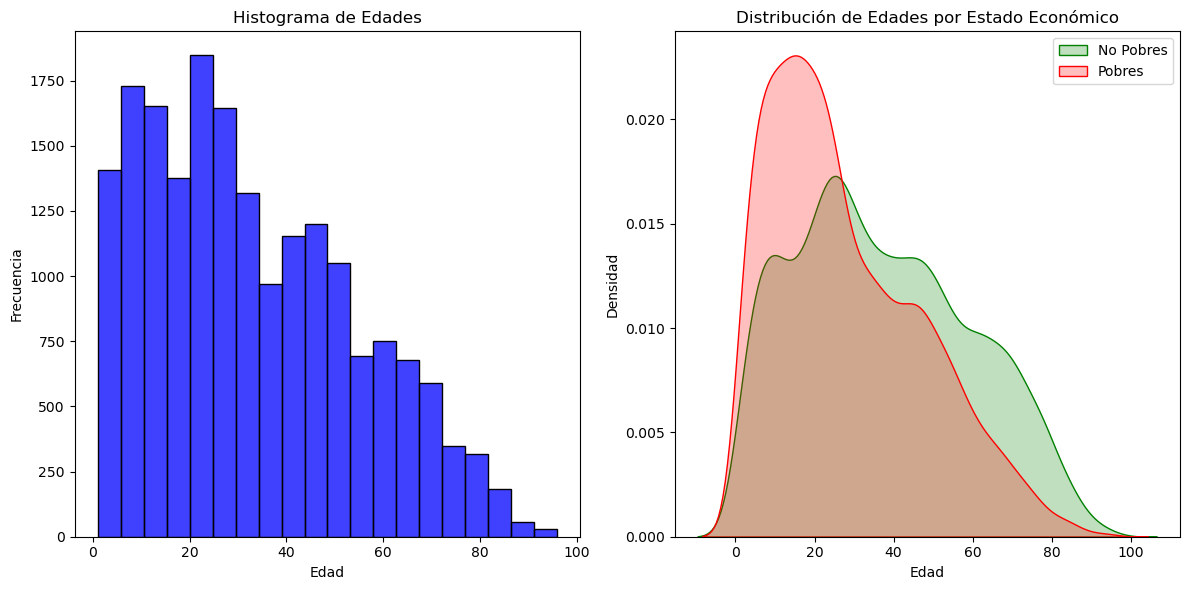

In [18]:
#CRE0 EDAD_2
union_eph['EDAD_2'] =  union_eph["CH06"].fillna(0) ** 2

# Configurar el gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# PANEL A: Historigrama de EDAD_2

sns.histplot(union_eph['CH06'], bins=20, kde=False, ax=axs[0], color='blue')

axs[0].set_title('Histograma de Edades')
axs[0].set_xlabel('Edad')
axs[0].set_ylabel('Frecuencia')

# PANEL B: Distribución de kernels para POBRES y NO POBRES

sns.kdeplot(data=union_eph[union_eph['pobre'] == 0], x='CH06', fill=True, label='No Pobres', ax=axs[1], color='green')
sns.kdeplot(data=union_eph[union_eph['pobre'] == 1], x='CH06', fill=True, label='Pobres', ax=axs[1], color='red')

axs[1].set_title('Distribución de Edades por Estado Económico')
axs[1].set_xlabel('Edad')
axs[1].set_ylabel('Densidad')
axs[1].legend()

# Para mostrar los gráficos
plt.tight_layout()
plt.show()


<h3 style="color: navy;">Parte I.2</h3>
<p> 
Cree la variable educ definida como la cantidad de años de educación. 
Use inteligentemente las variables CH12, CH13 y CH14 para crearla. Por ejemplo, si dice que el nivel más alto de educación 
es “Secundario” (CH12), “Sí” finalizo este nivel (CH13)  y el último año que aprobó (CH14) fue “sexto”, 
entonces puede asumir que tiene  educ=12, osea 12 años de educación formal. 

Presente una estadística descriptiva (promedio, sd, min, p50, max) de dicha variable creada y comente
</p>


In [19]:
#PRESCOLAR
union_eph.loc[(union_eph.CH12 == 1 ) & (union_eph.CH13 == 2), 'EDUC']=0
union_eph.loc[(union_eph.CH12 == 1 ) & (union_eph.CH13 == 1), 'EDUC']=0

#PRIMARIA (7 años mas)
union_eph.loc[(union_eph.CH12 == 2) & (union_eph.CH13  == 2), 'EDUC'] = union_eph['CH14']
union_eph.loc[(union_eph.CH12 == 2) & (union_eph.CH13  == 1), 'EDUC']= 7

#EGB (9 años mas)
union_eph.loc[(union_eph.CH12 == 3) & (union_eph.CH13  == 2), 'EDUC'] = union_eph['CH14']
union_eph.loc[(union_eph.CH12 == 3) & (union_eph.CH13  == 1), 'EDUC']=9

#SECUNDARIO (5 años mas)
union_eph.loc[(union_eph.CH12 == 4) & (union_eph.CH13  == 2), 'EDUC'] = union_eph['CH14'] + 7
union_eph.loc[(union_eph.CH12 == 4) & (union_eph.CH13  == 1 ), 'EDUC']=12

#POLIMODAL (3 años mas)
union_eph.loc[(union_eph.CH12 == 5) & (union_eph.CH13  == 2), 'EDUC'] = union_eph['CH14'] + 9
union_eph.loc[(union_eph.CH12 == 5) & (union_eph.CH13 == 1), 'EDUC']=12

#TERCIARIO (2 años mas)
union_eph.loc[(union_eph.CH12 == 6) & (union_eph.CH13  == 2), 'EDUC'] = union_eph['CH14'] + 12
union_eph.loc[(union_eph.CH12 == 6) & (union_eph.CH13 == 1), 'EDUC']=14

#UNIVERSITARIO (5 años mas)
union_eph.loc[(union_eph.CH12 == 7) & (union_eph.CH13  == 2), 'EDUC'] = union_eph['CH14'] + 12 
union_eph.loc[(union_eph.CH12 == 7) & (union_eph.CH13 == 1), 'EDUC']=17

#POSTGRADO (3 años mas)
union_eph.loc[(union_eph.CH12 == 8) & (union_eph.CH13  == 2), 'EDUC'] = union_eph['CH14'] + 17
union_eph.loc[(union_eph.CH12 == 8) & (union_eph.CH13 == 1), 'EDUC']=20

#ESPECIAL (como primaria)
union_eph.loc[(union_eph.CH12 == 9) & (union_eph.CH13  == 2), 'EDUC'] = union_eph['CH14'] 
union_eph.loc[(union_eph.CH12 == 9) & (union_eph.CH13 == 1), 'EDUC']=7



Estadísticas descriptivas de la variable EDUC:
count    17954.000000
mean         9.467974
std          4.506728
min          0.000000
25%          7.000000
50%         10.000000
75%         12.000000
max         20.000000
Name: EDUC, dtype: float64

Desviación estándar: 4.51


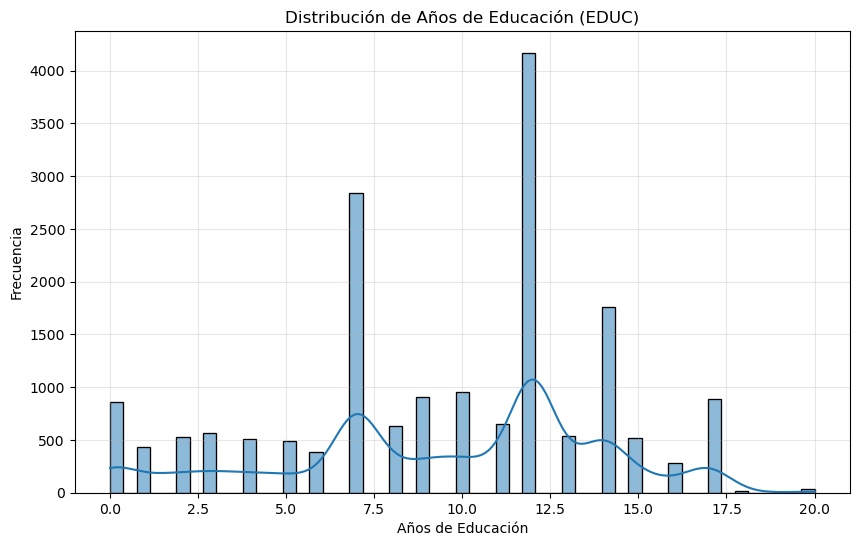

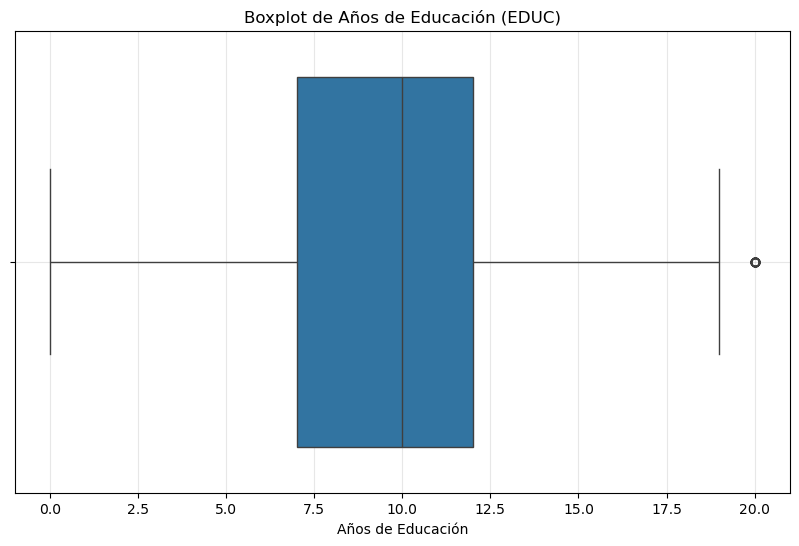

In [20]:

# Hago las estadísticas descriptivas

stats = union_eph['EDUC'].describe()

print("Estadísticas descriptivas de la variable EDUC:")
print(stats)

#Veo la desviación estándar específicamente

sd = union_eph['EDUC'].std()
print(f"\nDesviación estándar: {sd:.2f}")

# Histograma para visualizar la distribución

plt.figure(figsize=(10, 6))

sns.histplot(union_eph['EDUC'], kde=True)

plt.title('Distribución de Años de Educación (EDUC)')
plt.xlabel('Años de Educación')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)

plt.show()

# Distribución y los valores atípicos

plt.figure(figsize=(10, 6))

sns.boxplot(x=union_eph['EDUC'])

plt.title('Boxplot de Años de Educación (EDUC)')
plt.xlabel('Años de Educación')
plt.grid(True, alpha=0.3)

plt.show()

<h3 style="color: navy;">Parte I.3</h3>
<p> 
Actualice la variable ingreso_total_familiar con el total de ingresos habituales (ITF). 
Recuerde que los pesos de 2005 tienen un poder de compra distinto a los pesos de 2025 en el primer trimestre. 
<br> 
Convierta primero los ingresos de 2005 a pesos de 2025. Similar al ítem 1, presente en un panel A, 
un histograma de la variable ingreso_total_familiar y las distribuciones de kernels para pobres y no pobres en un panel B. 
<br> 
Comente brevemente la distribución de ingresos en estos dos panels (3-4 oraciones). 
<br> 
En cada panel, sume una linea vertical con la línea de la pobreza calculada en el TP2.
</p>

Inflación acumulada desde 1er Trim 2005 hasta el 1er Trim 2025: 64816.31%
Factor de actualización: 649.16


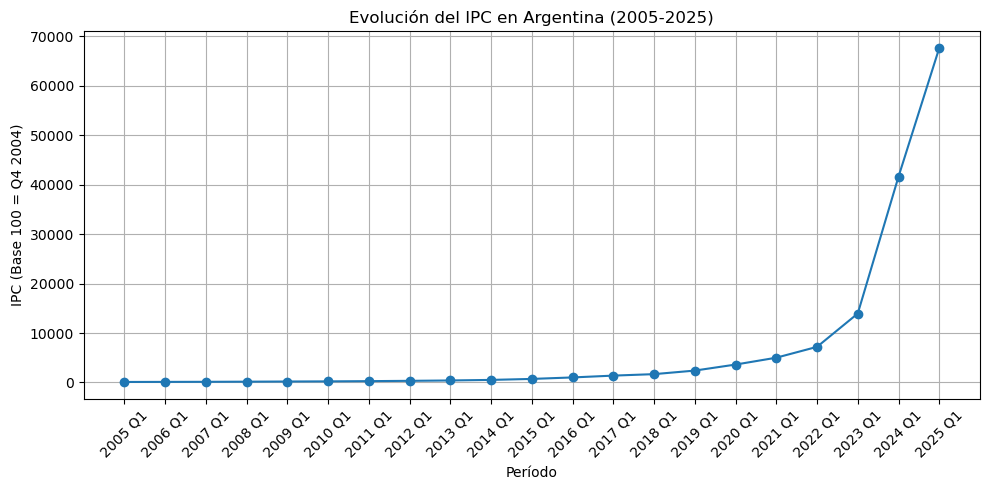

In [21]:
# Debido a la controversia sobre los datos del INDEC entre 2007-2015, utilizaremos allí el IPC Congreso
# Fuente 1: INDEC oficial para períodos 2005-2007 y 2016-2025
# Fuente 2: Estimaciones alternativas para 2007-2015 (IPC Congreso, consultoras privadas)

# Creo los trimestrales del periodo
periodos = []

for ANIO in range(2005, 2026):
    for trim in range(1, 5):
        if ANIO == 2025 and trim > 1:
            break
        periodos.append(f"{ANIO} Q{trim}")

# Estos son los valores
ipc_valores = [
    # 2005
    104.2, 107.8, 111.0, 114.8,
    # 2006
    118.9, 123.5, 127.2, 131.1,
    # 2007
    135.6, 141.2, 147.3, 153.8,
    # 2008
    162.5, 172.3, 181.4, 188.6,
    # 2009
    196.2, 203.5, 209.8, 216.3,
    # 2010
    224.8, 235.2, 246.3, 257.5,
    # 2011
    270.4, 285.6, 300.2, 315.8,
    # 2012
    332.1, 350.4, 368.2, 386.5,
    # 2013
    406.8, 430.2, 455.0, 481.3,
    # 2014
    520.6, 567.5, 615.8, 665.0,
    # 2015
    720.5, 782.3, 848.8, 925.2,
    # 2016
    1020.8, 1122.9, 1213.5, 1298.6,
    # 2017
    1388.5, 1456.9, 1518.5, 1585.8,
    # 2018
    1686.2, 1812.7, 1978.6, 2178.5,
    # 2019
    2405.3, 2685.9, 2954.5, 3294.1,
    # 2020
    3623.5, 3877.2, 4187.4, 4556.3,
    # 2021
    5012.0, 5513.2, 6009.4, 6550.2,
    # 2022
    7205.2, 8145.9, 9452.2, 11247.1,
    # 2023
    13946.4, 17851.4, 23206.8, 32025.4,
    # 2024
    41633.0, 49959.6, 57453.5, 63198.9,
    # 2025
    67642.8
]

# Cre0 el DataFrame con el diccionario
df = pd.DataFrame({
    'Periodo': periodos,
    'IPC': ipc_valores
})

# Calculo la inflación acumulada desde el 2005 hasta el 2025
inflacion_acumulada = (df['IPC'].iloc[-1] / df['IPC'].iloc[0] - 1) * 100


# El gráfico de la evolución del IPC
plt.figure(figsize=(10, 5))

plt.plot(df['Periodo'][::4], df['IPC'][::4], marker='o')  # Muestra un punto por año, para mejorar la visualización

plt.title('Evolución del IPC en Argentina (2005-2025)')
plt.xlabel('Período')
plt.ylabel('IPC (Base 100 = Q4 2004)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Mostrar el resultado
print(f"Inflación acumulada desde 1er Trim 2005 hasta el 1er Trim 2025: {inflacion_acumulada:.2f}%")
print(f"Factor de actualización: {df['IPC'].iloc[-1] / df['IPC'].iloc[0]:.2f}")

# Mostrar el gráfico
plt.show()

In [22]:
#Creo una columna nueva,ITF_05_25, de ITF a valores de 2025

union_eph.loc[(union_eph.ANIO == 2005 ) , 'ITF_05_25']=union_eph["ITF"].fillna(0)*(1+649.16)
union_eph.loc[(union_eph.ANIO == 2025 ) , 'ITF_05_25']=union_eph["ITF"].fillna(0)



In [23]:
html_texto = """
<p> 
En el Historigrama la mayor frecuencia se encuentra alrededor de los $400.000 de ITF. Siendo muy cercana 
a la línea verde representa la Canasta Básica Total, que se ubica en 365.177 miles.
<br>
En el grafico de densidad se visualiza nuevamente la gran relevancia de la pobreza en los mas jovenes y adicionalmente 
se puede observar la mayor amplitud en los niveles de ingresos de los no pobres en relacion la mayor frecuencia en los 
niveles de ingreso menores.  
</p>
"""

display(HTML(html_texto))

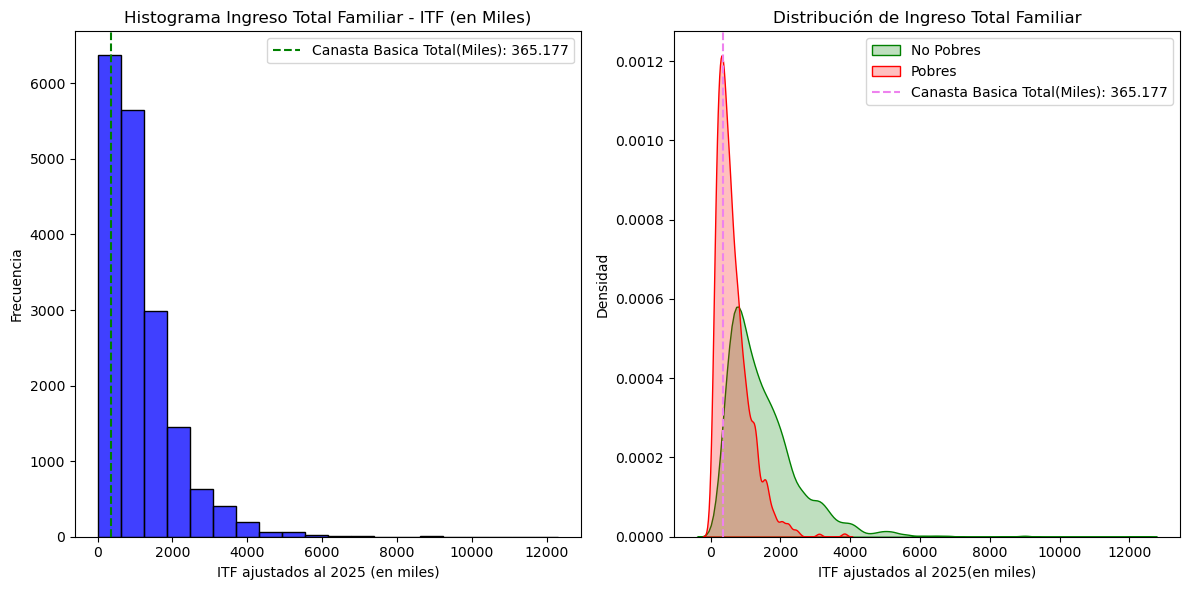

In [24]:

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Segun nos informaba el TP2 en el punto 7, el limite de pobreza era
cbt_pob_25=365.177

# Filtro y creo una copia para poder reducir optimizar la visualizacion en el grafico
union_itf = union_eph[(union_eph['pobre'].isin([0, 1])) & (union_eph['ITF_05_25'] != 0)].copy()
union_itf['ITF_05_25_2'] = union_itf['ITF_05_25'] / 1000


# PANEL A: Historigrama de Ingreso Total Familiar ajustados al 2025 

sns.histplot(data=union_itf['ITF_05_25_2'], bins=20, kde=False, ax=axs[0], color='blue')
axs[0].axvline(365.177, color='green', linestyle='--', label=f'Canasta Basica Total(Miles): {cbt_pob_25}')

axs[0].set_title('Histograma Ingreso Total Familiar - ITF (en Miles)')
axs[0].set_xlabel('ITF ajustados al 2025 (en miles)')
axs[0].set_ylabel('Frecuencia')
axs[0].legend()

# PANEL B: Distribución de kernels para POBRES y NO POBRES

sns.kdeplot(data=union_itf[union_itf['pobre'] == 0], x='ITF_05_25_2', fill=True, label='No Pobres', ax=axs[1], color='green')
sns.kdeplot(data=union_itf[union_itf['pobre'] == 1], x='ITF_05_25_2', fill=True, label='Pobres', ax=axs[1], color='red')

plt.axvline(cbt_pob_25, color='violet', linestyle='--', label=f'Canasta Basica Total(Miles): {cbt_pob_25}')

axs[1].set_title('Distribución de Ingreso Total Familiar')
axs[1].set_xlabel('ITF ajustados al 2025(en miles)')
axs[1].set_ylabel('Densidad')
axs[1].legend()

# Para mostrar los gráficos
plt.tight_layout()
plt.show()


<h3 style="color: navy;">Parte I.4</h3>
<p> 
Para el jefe del hogar, cree la variable horastrab como el total de horas trabajadas 
como la suma de las horas en la ocupación principal y otras ocupaciones (PP3E_TOT + PP3F_TOT). 
<br> 
Presente una estadística descriptiva (promedio, sd, min, p50, max) de dicha variable creada y comente</p>

In [25]:
html_texto = """
<p> 
El gráfico nos habla de que la mayoría de los jefes de hogar trabajan 
entre 20 y 80 horas por semana, con un pico alrededor de las 50 horas. <br>
Como muestra de ello, vemos la media en 42,19 (muy cerca de la mediana de 40) y un desvio standart cercano a la 20 hs
</p>
"""

display(HTML(html_texto))

Estadísticas descriptivas de la variable 'horastrab' de los Jef@s de hogares:
count    3096.000000
mean       40.902132
std        18.695289
min         1.000000
25%        30.000000
50%        40.000000
75%        50.000000
max       112.000000
Name: horastrab, dtype: float64

Desviación estándar: 18.70


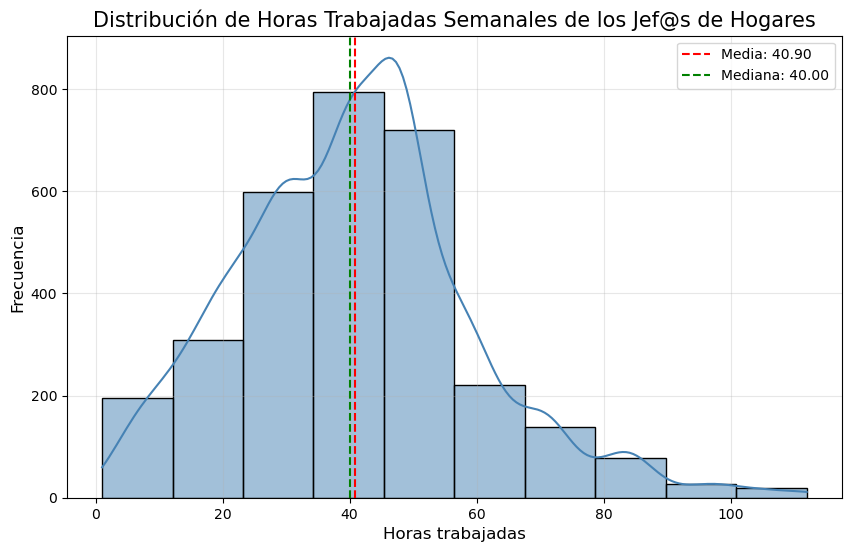

In [26]:

# Creo una nueva columna con la suma de horas semanales dedicadas a las actividades principales y a las secundarias, 
# donde conjuntamente no superen las 120hs (16hs diarias) y los ceros los vuelvo nulls para no distorcionar lo informado.

union_eph["horastrab"] = np.where((union_eph["PP3E_TOT"].fillna(0) + union_eph["PP3F_TOT"].fillna(0))>112,112,(union_eph["PP3E_TOT"].fillna(0) + union_eph["PP3F_TOT"].fillna(0)))
union_eph["horastrab"] = union_eph["horastrab"].replace(0, np.nan)

eph_jefehog = union_eph.loc[(union_eph.CH03 == 1 )]

# Las estadísticas descriptivas
stats = eph_jefehog["horastrab"].describe()
print("Estadísticas descriptivas de la variable 'horastrab' de los Jef@s de hogares:")
print(stats)

# La desviación estándar explícitamente
sd = eph_jefehog["horastrab"].std()
print(f"\nDesviación estándar: {sd:.2f}")

# El HISTOGRAMA
plt.figure(figsize=(10, 6))

sns.histplot(data=eph_jefehog, x="horastrab", bins=10, kde=True, color='steelblue')

plt.axvline(eph_jefehog["horastrab"].mean(), color='red', linestyle='--', label=f'Media: {eph_jefehog["horastrab"].mean():.2f}')
plt.axvline(eph_jefehog["horastrab"].median(), color='green', linestyle='--', label=f'Mediana: {eph_jefehog["horastrab"].median():.2f}')

plt.title('Distribución de Horas Trabajadas Semanales de los Jef@s de Hogares', fontsize=15)
plt.xlabel('Horas trabajadas', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

plt.legend()
plt.grid(True, alpha=0.3)


<h3 style="color: navy;">Parte I.5</h3>
<p> 
¿Cuál es el tamaño de la de la base de datos para su región con las variables originales unificadas? 
Para ello complete la tabla 1 que se le diseña abajo y comente.

In [27]:
# Me quedo solo con la región 40, NOA, que era nuestra region elegida.
df_region40 = union_eph[union_eph['REGION'] == 40]

# Crear el cuadro solicitado
# 1. Cantidad de observaciones
obs_2005 = len(df_region40[df_region40['ANIO'] == 2005])
obs_2025 = len(df_region40[df_region40['ANIO'] == 2025])
obs_total = obs_2005 + obs_2025

# 2. Cantidad de observaciones con NAs de "Pobre"
nas_2005 = df_region40[(df_region40['ANIO'] == 2005) & (df_region40['pobre'].isna())].shape[0]
nas_2025 = df_region40[(df_region40['ANIO'] == 2025) & (df_region40['pobre'].isna())].shape[0]
nas_total = nas_2005 + nas_2025

# 3. Cantidad de Pobres (pobre=1)
pobres_2005 = df_region40[(df_region40['ANIO'] == 2005) & (df_region40['pobre'] == 1)].shape[0]
pobres_2025 = df_region40[(df_region40['ANIO'] == 2025) & (df_region40['pobre'] == 1)].shape[0]
pobres_total = pobres_2005 + pobres_2025

# 4. Cantidad de No Pobres (pobre=0)
no_pobres_2005 = df_region40[(df_region40['ANIO'] == 2005) & (df_region40['pobre'] == 0)].shape[0]
no_pobres_2025 = df_region40[(df_region40['ANIO'] == 2025) & (df_region40['pobre'] == 0)].shape[0]
no_pobres_total = no_pobres_2005 + no_pobres_2025

# Los resultados
resultados = pd.DataFrame({
    '2005': [obs_2005, nas_2005, pobres_2005, no_pobres_2005,'28','22'],
    '2025': [obs_2025, nas_2025, pobres_2025, no_pobres_2025,'28','15'],
    'Total': [obs_total, nas_total, pobres_total, no_pobres_total,'28','22']
}, index=['Cantidad observaciones', 'Cant de observ con NAs en la vble "Pobre"', 
          'Cantidad de Pobres', 'Cantidad de No Pobres', 'Variables Orig Homogeneizadas','Cant Variables Orig Limpiadas'
         ])

print("\nCuadro de resultados para la región 40:")
print(resultados)

# Para ver que los números sean consistentes
print("\nVerificación de consistencia:")
print(f"Suma de pobres, no pobres y NAs en 2005: {pobres_2005 + no_pobres_2005 + nas_2005} (debe ser igual a {obs_2005})")
print(f"Suma de pobres, no pobres y NAs en 2025: {pobres_2025 + no_pobres_2025 + nas_2025} (debe ser igual a {obs_2025})")

# Porcentajes de pobreza (excluyendo NAs)
porc_pobres_2005 = pobres_2005 / (pobres_2005 + no_pobres_2005) * 100 if (pobres_2005 + no_pobres_2005) > 0 else 0
porc_pobres_2025 = pobres_2025 / (pobres_2025 + no_pobres_2025) * 100 if (pobres_2025 + no_pobres_2025) > 0 else 0
porc_pobres_total = pobres_total / (pobres_total + no_pobres_total) * 100 if (pobres_total + no_pobres_total) > 0 else 0

print("\nPorcentajes de pobreza (excluyendo NAs):")
print(f"Porcentaje de pobres en 2005: {porc_pobres_2005:.2f}%")
print(f"Porcentaje de pobres en 2025: {porc_pobres_2025:.2f}%")
print(f"Porcentaje de pobres total: {porc_pobres_total:.2f}%")



Cuadro de resultados para la región 40:
                                           2005  2025  Total
Cantidad observaciones                     9244  9762  19006
Cant de observ con NAs en la vble "Pobre"     0     0      0
Cantidad de Pobres                         4142  4965   9107
Cantidad de No Pobres                      5102  4797   9899
Variables Orig Homogeneizadas                28    28     28
Cant Variables Orig Limpiadas                22    15     22

Verificación de consistencia:
Suma de pobres, no pobres y NAs en 2005: 9244 (debe ser igual a 9244)
Suma de pobres, no pobres y NAs en 2025: 9762 (debe ser igual a 9762)

Porcentajes de pobreza (excluyendo NAs):
Porcentaje de pobres en 2005: 44.81%
Porcentaje de pobres en 2025: 50.86%
Porcentaje de pobres total: 47.92%


<span style="color:#1e90ff">Parte II: Métodos No Supervisados</span>

Esta parte del trabajo práctico tiene como objetivo que realicen un análisis visual de los datos utilizando las herramientas vistas en clase. En esta parte, solo necesita utilizar las variables: edad, edad2, educ, ingreso_total_familiar (ITF), el número de miembros en el hogar (2005 = IX_TOT, 2025 = IX_Tot) y horastrab.


1. Realice una matriz de correlaciones con estos seis predictores para su región y comente los resultados

In [28]:
# Agrego una condicion a la variable horas trabajadas para distinguir entre los valores con 0 y los nan que puedo eliminar en la variable educacion
condicion = union_eph['ESTADO'].isin([2, 3, 4])
union_eph.loc[condicion, 'horastrab'] = 0
#Armo la base de datos
var_Mns = ['IX_TOT','EDAD_2','ITF_05_25','horastrab','EDUC','CH06']
MnS_Data = union_eph[var_Mns]
MnS_Data.columns = ['Miembros_Hogar', 'Edad_Cuadrado', 'Ingreso', 'HsTrabajadas', 'AniosEducacion', 'Edad']
MnS_Data

,Miembros_Hogar,Edad_Cuadrado,Ingreso,HsTrabajadas,AniosEducacion,Edad
0,5.0,1296.0,455112.0,46.0,9.0,36.0
1,5.0,1225.0,455112.0,0.0,7.0,35.0
2,5.0,225.0,455112.0,0.0,10.0,15.0
3,5.0,144.0,455112.0,0.0,8.0,12.0
4,5.0,100.0,455112.0,0.0,5.0,10.0
...,...,...,...,...,...,...
19001,3.0,8100.0,3750000.0,0.0,12.0,90.0
19002,3.0,3600.0,3750000.0,NaN,17.0,60.0
19003,3.0,484.0,3750000.0,0.0,15.0,22.0
19004,2.0,625.0,1075000.0,36.0,7.0,25.0


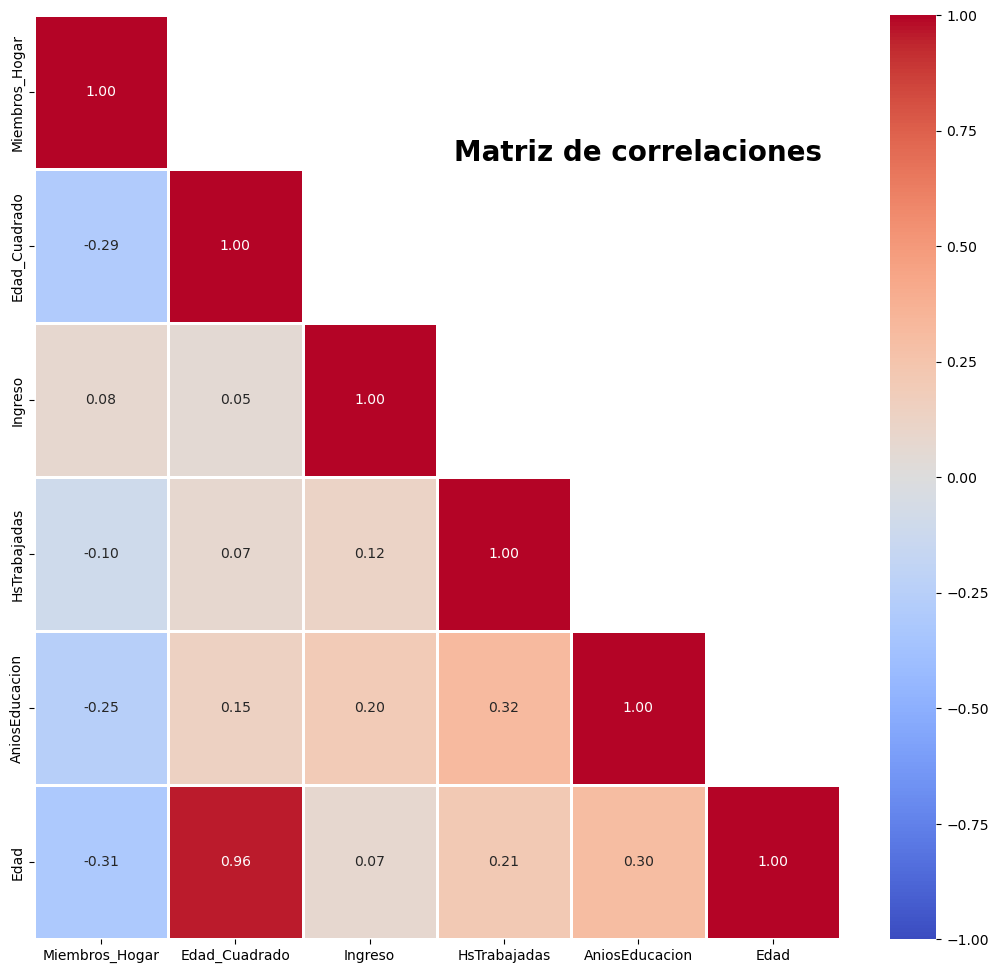

In [29]:
upp_mat = np.triu(MnS_Data.corr())
plt.figure(figsize=(13, 12))
upp_mat = np.triu(MnS_Data.corr(),k=1)
sns.heatmap(MnS_Data.corr(), vmin=-1, vmax=+1, annot=True, cmap="coolwarm", fmt=".2f",linewidths=1, mask = upp_mat)
plt.text(x=4.5,  y=1,  s='Matriz de correlaciones\n',horizontalalignment='center',verticalalignment='center', fontsize=20,fontweight='bold')
plt.gca().grid(False)

A. PCA

2. PCA con ingreso: Apliquen PCA a las seis variables seleccionadas para esta parte. Recuerde primero estandarizar las variables como vimos en la tutorial. En un gráfico de dispersión muestren los índices (scores) calculados del primer y segundo componente de PCA y comente los resultados. 

In [30]:
#Para esta parte me quedo solo con los valores que se pudieron recolectar. Aquellos que se encuentran NAN no se usaran para el analis.
MnS_Data = MnS_Data.dropna()
MnS_Data

,Miembros_Hogar,Edad_Cuadrado,Ingreso,HsTrabajadas,AniosEducacion,Edad
0,5.0,1296.0,455112.0,46.0,9.0,36.0
1,5.0,1225.0,455112.0,0.0,7.0,35.0
2,5.0,225.0,455112.0,0.0,10.0,15.0
3,5.0,144.0,455112.0,0.0,8.0,12.0
4,5.0,100.0,455112.0,0.0,5.0,10.0
...,...,...,...,...,...,...
19000,5.0,144.0,1800000.0,0.0,8.0,12.0
19001,3.0,8100.0,3750000.0,0.0,12.0,90.0
19003,3.0,484.0,3750000.0,0.0,15.0,22.0
19004,2.0,625.0,1075000.0,36.0,7.0,25.0


In [31]:
#Estandarizamos los datos
scaler = StandardScaler(with_std=True, with_mean=True) 
# Aplicamos fit_transform al DataFrame
Pca_data = pd.DataFrame(scaler.fit_transform(MnS_Data), columns=MnS_Data.columns)
Pca_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17216 entries, 0 to 17215
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Miembros_Hogar  17216 non-null  float64
 1   Edad_Cuadrado   17216 non-null  float64
 2   Ingreso         17216 non-null  float64
 3   HsTrabajadas    17216 non-null  float64
 4   AniosEducacion  17216 non-null  float64
 5   Edad            17216 non-null  float64
dtypes: float64(6)
memory usage: 807.1 KB


In [32]:
pca = PCA()
eph_pca = pca.fit_transform(Pca_data)
scores = eph_pca
eph_pca

array([[ 0.14146057,  0.46988365, -0.68021797,  1.24314008, -0.30525083,
         0.08642493],
       [-0.5186592 , -0.91734211, -0.09195588, -0.00524763,  0.18574029,
         0.26907075],
       [-1.21765566, -0.18976627, -0.58431058, -0.38639129,  0.59208917,
        -0.08124362],
       ...,
       [ 0.06770021,  1.96226839,  1.06377655, -2.55612118, -0.17915273,
         0.02437724],
       [-0.16214809,  0.44674449, -0.98456536, -0.05190442, -1.30230601,
         0.09014739],
       [-0.04309891,  0.7633584 , -1.15985587, -0.69796035, -0.31360544,
        -0.03071049]])

In [33]:
loading_vectors = pca.components_ # cada fila corresponde a un CP y cada columna, a una variable
print("Loadings:\n", pca.components_)
print("Loadings del CP1:\n",pca.components_[0]) 
pca.components_[0,0] #loadings del CP1 variable 1, phi(1,1) en ecuacion 4

Loadings:
 [[-0.34173248  0.57770448  0.09468439  0.21960168  0.33678438  0.61551824]
 [ 0.08508188 -0.33071431  0.50662316  0.56796944  0.51259922 -0.20340807]
 [ 0.59065627  0.26266863  0.65706778 -0.24257019 -0.23224798  0.19394037]
 [ 0.5487493   0.11429812 -0.43354508  0.64392869 -0.2372055   0.16412861]
 [ 0.47504794 -0.0093001  -0.33807385 -0.38852816  0.70949728  0.07489002]
 [-0.01757335 -0.68901394  0.01935214 -0.06890011 -0.10112546  0.71386474]]
Loadings del CP1:
 [-0.34173248  0.57770448  0.09468439  0.21960168  0.33678438  0.61551824]


np.float64(-0.3417324750013507)

In [34]:
#Comprobamos la condicion de los loadings del CP1
(-0.34173248)**2+(0.57770448)**2+(0.09468439)**2+( 0.21960168)**2+(0.33678438)**2+(0.61551824)**2

1.0000000080521974

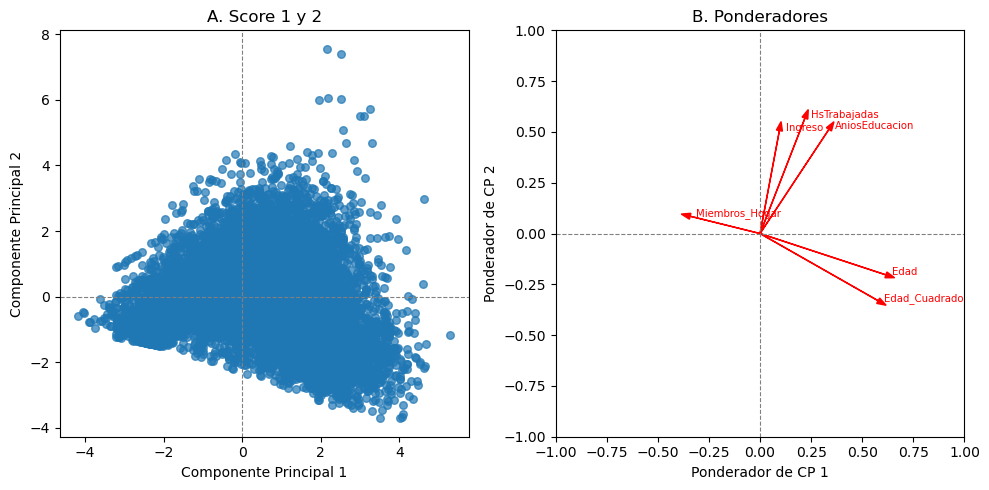

In [35]:
i, j = 0, 1 # Componentes
fig, (ax_scores, ax_ponderadores) = plt.subplots(1, 2, figsize=(10, 5)) # 1 fila, 2 columnas
# ---
## Panel A. Score 1 y 2
ax_scores.scatter(scores[:,0], scores[:,1], s=30, alpha=0.7) # graficamos los valores de los CP1 y CP2
ax_scores.set_xlabel('Componente Principal %d' % (i+1))
ax_scores.set_ylabel('Componente Principal %d' % (j+1))
ax_scores.set_title('A. Score 1 y 2')
# Líneas punteadas en los ejes
ax_scores.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Eje horizontal en y=0
ax_scores.axvline(0, color='gray', linestyle='--', linewidth=0.8) # Eje vertical en x=0
# ---
## Panel B. Ponderadores
# Líneas punteadas en los ejes
ax_ponderadores.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Eje horizontal en y=0
ax_ponderadores.axvline(0, color='gray', linestyle='--', linewidth=0.8) # Eje vertical en x=0
# ponderadores
for k in range(pca.components_.shape[1]): # loop que itera por la cantidad de features
    ax_ponderadores.arrow(0, 0, pca.components_[i,k], pca.components_[j,k], color ='red', head_width=0.03) # flecha desde el origen (0) a las coordenadas
    ax_ponderadores.text(pca.components_[i,k]+0.03, pca.components_[j,k], Pca_data.columns[k], color ='red',fontsize=7.3) # al final de cada flecha, nombre de la variable
ax_ponderadores.set_xlabel('Ponderador de CP %d' % (i+1))
ax_ponderadores.set_ylabel('Ponderador de CP %d' % (j+1))
ax_ponderadores.set_title('B. Ponderadores')
ax_ponderadores.set_xlim(-1, 1)
ax_ponderadores.set_ylim(-1, 1)
plt.tight_layout() # Ajusta los subplots para que no se superpongan
plt.show()

In [36]:
print(pca.explained_variance_ratio_)

[0.38525844 0.21450067 0.16744034 0.13014826 0.09977114 0.00288115]


In [37]:
#Comprobamos que la suma de 1
0.38525844  +0.21450067  +0.16744034 +0.13014826 +0.09977114+0.00288115

0.9999999999999999

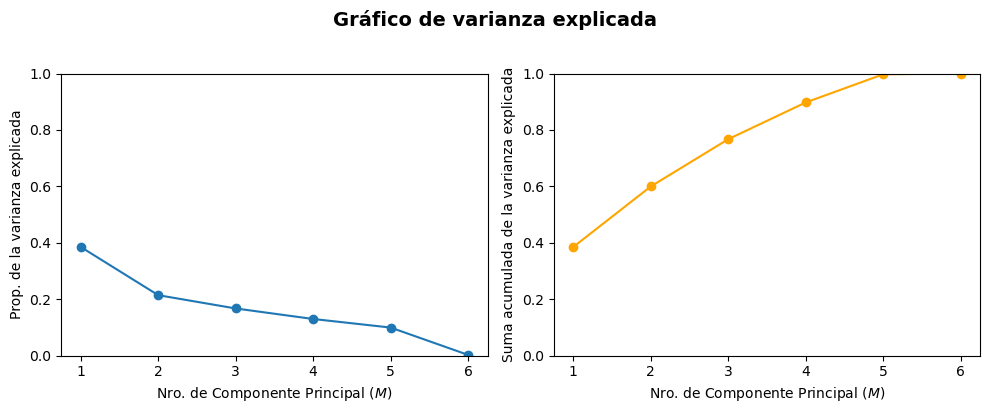

In [38]:
# Armamos el gráfico
plt.close('all')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ticks = np.arange(pca.n_components_) + 1

# Título general de la figura
fig.suptitle("Gráfico de varianza explicada", fontsize=14, fontweight="bold", y=1.02)

# Subplot 1: varianza explicada por componente
ax = axes[0]
ax.plot(ticks, pca.explained_variance_ratio_, marker='o')
ax.set_xlabel('Nro. de Componente Principal ($M$)')
ax.set_ylabel('Prop. de la varianza explicada')
ax.set_ylim([0, 1])
ax.set_xticks(ticks)

# Subplot 2: varianza explicada acumulada
ax = axes[1]
ax.plot(ticks, pca.explained_variance_ratio_.cumsum(), marker='o', color="orange")
ax.set_xlabel('Nro. de Componente Principal ($M$)')
ax.set_ylabel('Suma acumulada de la varianza explicada')
ax.set_ylim([0, 1])
ax.set_xticks(ticks)

plt.tight_layout()
plt.show()

B. Cluster

5.  Cluster k-medias: 

a.   Corran el algoritmo con k=2, k=4 y k=10 usando n_init = 20, y grafiquen los resultados usando edad e ingreso familiar. Interprétenlos ¿Puede el algoritmo con k=2 separar correctamente a las personas pobres y no pobres en su región?


In [39]:
## Al utilizar variables que contienen todos los individuos armo nuevamente la base de datos para esta parte
X = union_eph[['CH06', 'ITF_05_25']].dropna() 
X.columns = ['Edad','Ingreso']
X

,Edad,Ingreso
0,36.0,455112.0
1,35.0,455112.0
2,15.0,455112.0
3,12.0,455112.0
4,10.0,455112.0
...,...,...
19001,90.0,3750000.0
19002,60.0,3750000.0
19003,22.0,3750000.0
19004,25.0,1075000.0


In [40]:
# Definimos los distintos k
ks = [2, 4, 10]
modelos = {}

for k in ks:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    X[f'cluster_{k}'] = kmeans.fit_predict(X[['Edad', 'Ingreso']])
    modelos[k] = kmeans

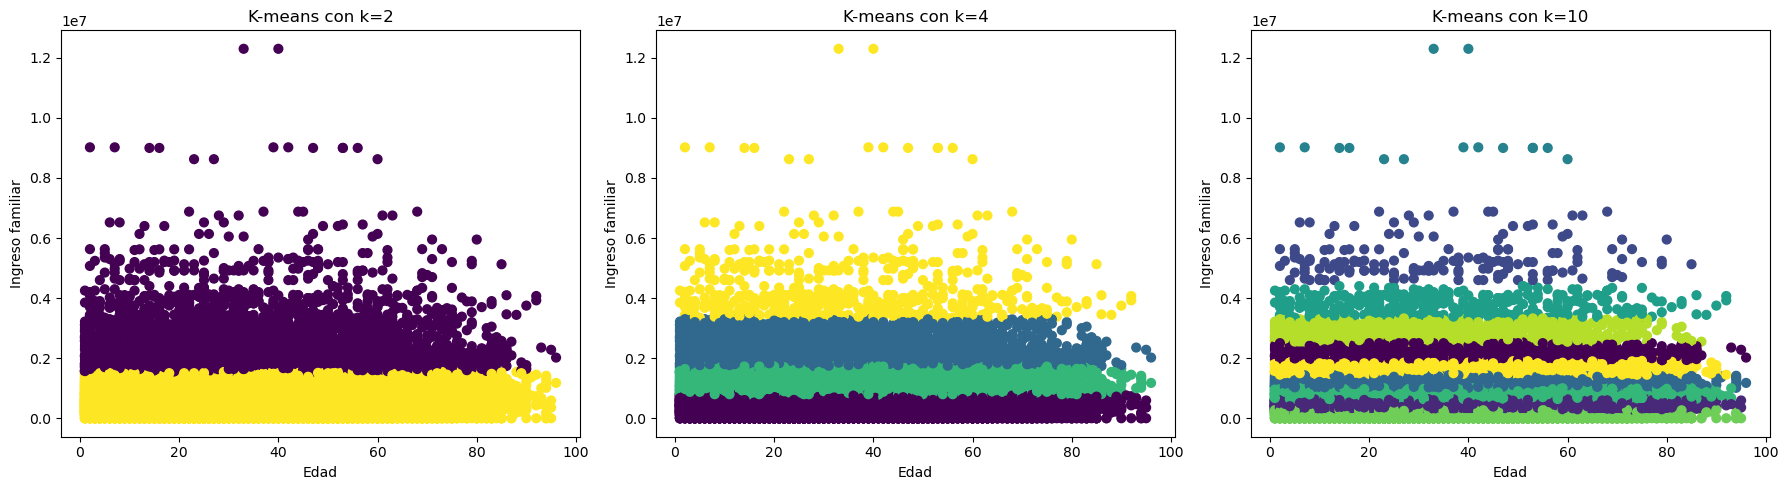

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, k in enumerate(ks):
    ax = axes[i]
    ax.scatter(X['Edad'], X['Ingreso'], c=X[f'cluster_{k}'], cmap='viridis', s=40)
    ax.set_title(f'K-means con k={k}')
    ax.set_xlabel('Edad')
    ax.set_ylabel('Ingreso familiar')
plt.tight_layout()
plt.show()

b.	Grafique alguna medida de disimilitud para k=1 hasta k=10. Usando la inspección visual de Elbow ¿cuál sería el número óptimo de clusters en su región? ¿Dicha cantidad de grupos nos ayudaría a distinguir entre pobres y no pobres o entre distintas clases socioeconómicas? 

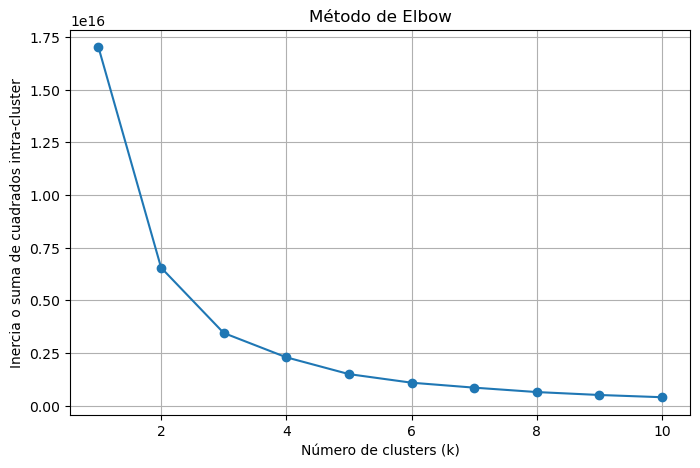

In [42]:
inertias = []
K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertias, marker='o')
plt.title('Método de Elbow')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia o suma de cuadrados intra-cluster')
plt.grid(True)
plt.show()

6.	Cluster jerárquico: Utilizando las variables mencionadas arriba, realicen un análisis de clustering jerárquico. Generen un dendograma y expliquen brevemente qué es un dendograma.

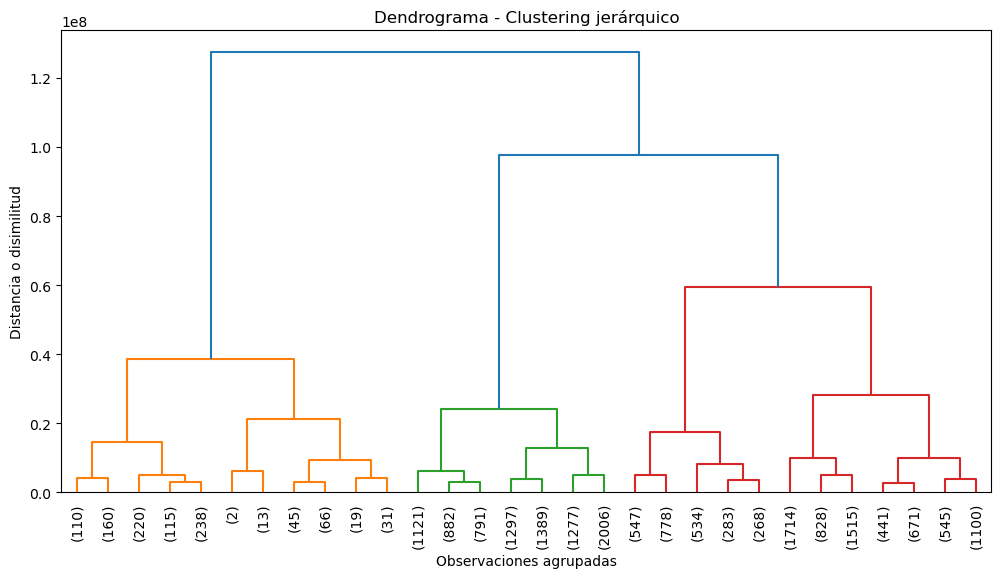

In [43]:
# Calculo la matriz de ligamiento 
Z = linkage(X, method='ward')

# Genero el dendrograma
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrograma - Clustering jerárquico')
plt.xlabel('Observaciones agrupadas')
plt.ylabel('Distancia o disimilitud')
plt.show()